# GenAI in Education — Cleaning & EDA
Notebook to explore and clean the scraped dataset, then export a cleaned CSV.

**Steps included**
1. Load RAW dataset
2. Explore (missing values, top sources, date distribution, text length)
3. Cleaning pipeline (normalize text, standardize dates, fill/derive source names, validate links, deduplicate)
4. Save cleaned CSV


In [57]:
import re, unicodedata
from urllib.parse import urlparse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

INPUT_PATH = "data/raw_genai-education_2023-2025.csv"
OUTPUT_PATH = "data/clean_genai-education_2023-2025.csv"

pd.set_option("display.max_colwidth", 200)

In [58]:
df = pd.read_csv(INPUT_PATH)
print("Rows, Columns:", df.shape)
df.head(3)

Rows, Columns: (229, 4)


,source_name,date,text,link
0,Reddit,May 2025,"Generative AI, most notably ChatGPT, has and is continuing to change the landscape of education. But this also comes with negative side effects, especially students relying on AI to plagirize thei...",https://www.reddit.com/r/edtech/comments/1l5b9t0/thoughts_on_usage_of_ai_in_school_coursework/
1,Gizmodo,2025-08-16 12:00:42+00:00,"Film Schools Are Embracing AI. Should They? Generative AI has come for America's film students. Jake Panek, a 20-year-old film major, says he’s had a great time at DePaul University in Chicago, an...",https://gizmodo.com/film-schools-are-embracing-ai-should-they-2000639311
2,Windows Central,2025-08-19 15:11:27+00:00,"Ex-Google GenAI founder says ""AI is going to be gone by the time you finish a PhD"" — higher education degrees can't keep up Jad Tarifi, founder of Google’s first generative AI team, says pursuing ...",https://www.windowscentral.com/artificial-intelligence/ex-google-genai-founder-ai-gone-by-the-time-you-finish-phd


In [59]:
df.isnull().sum().to_frame("missing_count")

,missing_count
source_name,1
date,5
text,1
link,1


In [60]:
URL_RE = re.compile(r'https?://\S+|www\.\S+')
EMAIL_RE = re.compile(r'\b[\w\.-]+@[\w\.-]+\.\w+\b')
TRUNCATION_RE = re.compile(r"\.\s*\[\+\d+\s*chars\]", flags=re.IGNORECASE)  # e.g., "... [+7735 chars]"

def is_valid_url(url: str) -> bool:
    if not isinstance(url, str) or not url.strip():
        return False
    try:
        u = urlparse(url)
        return bool(u.scheme and u.netloc)
    except Exception:
        return False

def normalize_confusables(text: str) -> str:
    """
    Normalize Unicode punctuation likely to be confused in source text.
    NOTE: You asked specifically to treat U+2019 (’ right single quote)
    as the ASCII backtick U+0060 (`), since that's more common in your source.
    """
    if not isinstance(text, str):
        return text
    # First do NFKC normalization to reduce odd forms
    text = unicodedata.normalize("NFKC", text)

    # Map of confusables -> target ASCII
    # You can extend this mapping to include more punctuation if needed.
    confusables_map = {
        "\u2019": "`",  # RIGHT SINGLE QUOTATION MARK ’ -> backtick `
        "\u2018": "`",  # LEFT SINGLE QUOTATION MARK ‘ -> backtick `
        "\u201C": '"',  # LEFT DOUBLE QUOTATION MARK “ -> "
        "\u201D": '"',  # RIGHT DOUBLE QUOTATION MARK ” -> "
        "\u00B4": "`",  # ACUTE ACCENT ´ -> `
        "\u2032": "'",  # PRIME ′ -> '
        "\u2033": '"',  # DOUBLE PRIME ″ -> "
        "\u2014": "-",  # EM DASH — -> -
        "\u2013": "-",  # EN DASH – -> -
        "\u00A0": " ",  # NO-BREAK SPACE -> regular space
    }
    # Translate using a table
    trans_table = str.maketrans(confusables_map)
    text = text.translate(trans_table)

    # Collapse excessive whitespace
    text = " ".join(text.split())
    return text

def replace_specials(text: str) -> str:
    """Replace URLs/emails inside text with placeholders (keep semantics)."""
    if not isinstance(text, str):
        return text
    text = URL_RE.sub("<URL>", text)
    text = EMAIL_RE.sub("<EMAIL>", text)
    return text

def coerce_date_any(x):
    """
    Robust date parsing:
    - Try pandas to_datetime (handles ISO and many formats).
    - If fail, try Month Year (e.g., 'May 2025').
    Returns timezone-aware UTC timestamps or NaT.
    """
    if pd.isna(x):
        return pd.NaT
    dt = pd.to_datetime(x, errors="coerce", utc=True)
    if pd.isna(dt):
        try:
            dt = pd.to_datetime(str(x), format="%B %Y", utc=True)
        except Exception:
            dt = pd.NaT
    return dt

def impute_missing_dates(series_dt: pd.Series, group_keys=None) -> pd.Series:
    """
    Impute NaT dates.
    Strategy:
      1) If group_keys provided (e.g., by source), impute with group median.
      2) Fallback to global median.
      3) If all missing, keep as NaT.
    """
    s = series_dt.copy()

    # Helper to compute safe median for datetime64[ns, UTC]
    def _median_datetime(x: pd.Series):
        x = x.dropna()
        if x.empty:
            return pd.NaT
        # Convert to int64 ns to compute median, then back
        vals = x.view("int64").sort_values().to_numpy()
        med = np.median(vals)
        try:
            return pd.to_datetime(int(med), utc=True)
        except Exception:
            return pd.NaT

    if group_keys is not None:
        med_by_group = s.groupby(group_keys, dropna=False).transform(_median_datetime)
        s = s.fillna(med_by_group)

    global_med = _median_datetime(s)
    if pd.isna(global_med):
        # nothing to impute with; return as-is
        return s

    s = s.fillna(global_med)
    return s


In [61]:
df['source_name_norm'] = df['source_name'].apply(std_source_name)
df['source_name_norm'].fillna("Unknown").value_counts().head(20)

source_name_norm
Zenodo                 66
Reddit                 54
X                      33
Aimultiple             10
Fullestop Blog          8
Nationalcentreforai     7
Weforum                 6
Eklavvya Blog           6
Inside Higher Ed        4
Windows Central         3
Ed Tech Digest          2
Ed Week                 2
Gizmodo                 2
Psychology Today        1
Teaching Times          1
Inspera                 1
UNESCO                  1
APA Monitor             1
USD Blog                1
Edweek                  1
Name: count, dtype: int64

Parsed date coverage: 0.9737991266375546


/var/folders/4d/c9fb2t_j5znf_ftgytncz11h0000gp/T/ipykernel_5438/1175482285.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  monthly['year_month'] = monthly['_date_parsed'].dt.to_period('M').astype(str)


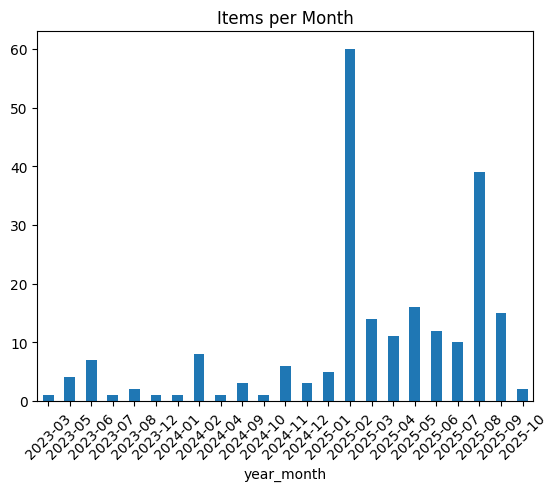

In [62]:
df['_date_parsed'] = df['date'].apply(coerce_date_any)
print("Parsed date coverage:", df['_date_parsed'].notna().mean())

monthly = df.dropna(subset=['_date_parsed']).copy()
if not monthly.empty:
    monthly['year_month'] = monthly['_date_parsed'].dt.to_period('M').astype(str)
    counts = monthly['year_month'].value_counts().sort_index()
    counts.plot(kind='bar', rot=45, title='Items per Month')

In [63]:
df['text_len'] = df['text'].astype(str).str.len()
df['text_len'].describe(percentiles=[.5,.9,.95,.99])

count     229.000000
mean      379.152838
std       602.891569
min         3.000000
50%       193.000000
90%       763.400000
95%      1313.200000
99%      2144.000000
max      7081.000000
Name: text_len, dtype: float64

<Axes: title={'center': 'Text Length Distribution'}, ylabel='Frequency'>

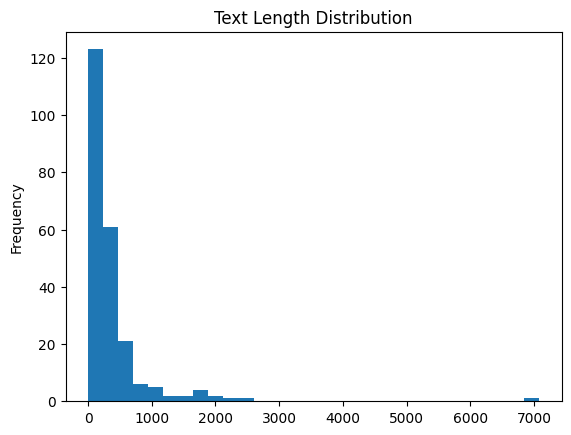

In [64]:
df['text_len'].dropna().plot(kind='hist', bins=30, title='Text Length Distribution')

## Cleaning Pipeline

In [65]:
clean = df.copy()

# 0) Basic trims; keep missing source names (do NOT drop)
for col in ["source_name", "text", "link", "date"]:
    if col in clean.columns:
        clean[col] = clean[col].apply(lambda x: x if not isinstance(x, str) else x.strip())

# 1) Normalize confusables (e.g., ’ -> `), collapse whitespace
clean["text_norm"] = clean["text"].apply(normalize_confusables)

# 2) Replace specials (URLs/emails) but keep semantics
clean["text_clean"] = clean["text_norm"].apply(replace_specials)

# 3) Drop rows where text contains truncation markers like "... [+7735 chars]"
mask_trunc = clean["text_clean"].astype(str).str.contains(TRUNCATION_RE)
clean = clean[~mask_trunc].copy()

# 4) Validate link (keep rows even if link missing/invalid; we just flag it)
clean["link_valid"] = clean["link"].apply(is_valid_url)

# 5) Parse dates, then IMPUTE missing dates (do not drop)
clean["date_parsed"] = clean["date"].apply(coerce_date_any)

# Impute by source_name first (preserving missing source names by treating NaN as its own group),
# then fallback to global median.
clean["date_imputed"] = impute_missing_dates(clean["date_parsed"], group_keys=clean["source_name"])

# 6) Deduplicate:
#    Keep rows with the same link UNLESS the text is different.
#    That means we remove *exact* duplicates only when both 'link' and 'text_clean' match.
before = len(clean)
clean = clean.drop_duplicates(subset=["link", "text_clean"], keep="first")
after = len(clean)
print(f"Removed {before - after} exact duplicates on (link, text_clean).")

Removed 4 exact duplicates on (link, text_clean).


In [ ]:
# 7) Final selection (do NOT drop missing source names)
out = clean.copy()
out = out.rename(columns={"date_imputed": "date_clean"})
# Keep both original and cleaned variants for auditability if you like; otherwise select minimal columns:
out = out[[
    "source_name",       # may be missing; we keep it
    "date_clean",        # imputed date (never NaT if median existed)
    "text_clean",        # normalized + placeholders
    "link",
]].reset_index(drop=True)

out.to_csv(OUTPUT_PATH, index=False)
out.head(10)

,source_name,date_clean,text_clean,link
0,Reddit,2025-05-01 00:00:00+00:00,"Generative AI, most notably ChatGPT, has and is continuing to change the landscape of education. But this also comes with negative side effects, especially students relying on AI to plagirize thei...",https://www.reddit.com/r/edtech/comments/1l5b9t0/thoughts_on_usage_of_ai_in_school_coursework/
1,Reddit,2025-05-09 20:18:16+00:00,"As a parent with two children (8yo and 9yo) in elementary school, this is a huge concern of mine. Thankfully, they only do pencil on paper writing assignments for now. I don`t give them access to ...",https://www.reddit.com/r/education/comments/1kim0ss/ai_is_ruining_education/mrh7sgn/
2,Reddit,2025-05-13 17:59:59+00:00,teaching kids how to use AI to better prepare for future job markets ≠ letting kids use AI for every single task and domain you possibly can in a classroom. have AI classes. teach kids how LLMs ac...,https://www.reddit.com/r/education/comments/1kim0ss/ai_is_ruining_education/ms4pik8/
3,Reddit,2025-04-29 09:32:21+00:00,"Seeking Global Perspectives on AI Integration in Education Hello everyone, I'm interested in engaging in a global dialogue about the integration of generative AI in education. I`ll start by sharin...",https://www.reddit.com/r/edtech/comments/1kajtwe/seeking_global_perspectives_on_ai_integration_in/
4,Reddit,2024-10-23 23:34:20+00:00,"Took this course back in April & even as a tech coach who has kept up with AI, felt it was worthwhile enough to suggest to my admin to offer our staff PD, here's the email I sent them: Hey all - a...",https://www.reddit.com/r/edtech/comments/1gab8d7/experiences_with_the_google_generative_ai_for/ltfecux/
5,Reddit,2024-01-23 18:32:59+00:00,Seeking Collaboration with Education Researchers on AI Platform Data Review and Distribution Hello all! I'm reaching out to this community as I`m looking for researchers interested in the intersec...,https://www.reddit.com/r/education/comments/19dvakj/seeking_collaboration_with_education_researchers/
6,Reddit,2023-05-14 16:47:18+00:00,G-7 education ministers confirm need to curb risks from generative AI,https://www.reddit.com/r/technology/comments/13hh2jq/g7_education_ministers_confirm_need_to_curb_risks/
7,Reddit,2023-05-15 00:21:58+00:00,I celebrate the end of writing boring essays. But on the other hand I understand that they were trying to teach reading comprehension and communication skills. If students already have those skill...,https://www.reddit.com/r/technology/comments/13hh2jq/g7_education_ministers_confirm_need_to_curb_risks/jk6jg2d/
8,Reddit,2023-05-15 01:20:54+00:00,>If students already have those skills it's fine if they use generative AI. It could have a crippling effect on those that don't have those skills and will never develop them. That is the point. W...,https://www.reddit.com/r/technology/comments/13hh2jq/g7_education_ministers_confirm_need_to_curb_risks/jk6q8f9/
9,Reddit,2023-08-14 23:28:01+00:00,"Videos of recent ""AI in Education"" meeting The Rocky Mountain AI Interest Group (RMAIIG) held a hybrid in-person/online meeting on Aug 8, 2023 on the topic of ""AI in Education."" I'm sharing the vi...",https://www.reddit.com/r/edtech/comments/15ravmx/videos_of_recent_ai_in_education_meeting/


In [67]:
out['source_name'].fillna('Unknown').value_counts().head(10)

source_name
Zenodo                 65
Reddit                 54
X                      30
AIMultiple             10
Fullestop Blog          8
nationalcentreforai     7
weforum                 6
Eklavvya Blog           6
Ed Tech Digest          2
Ed Week                 2
Name: count, dtype: int64